## Linear Regression

Linear Regression is one of the most basic forms of machine learning and is used to predict numeric values.

Demonstration using a basic data set : 

(0.0, 6.0, 0.0, 20.0)

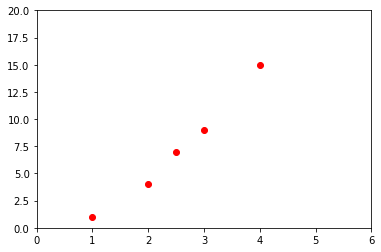

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

x = [1,2,2.5,3,4]
y = [1,4,7,9,15]
plt.plot(x,y,'ro')
plt.axis([0,6,0,20])

As seen from the graph above, the x and y values have somewhat of a linear correspondance, and a line called as the 
"Line of best fit" can be plotted in order to predict more values.


**Line of best fit** : Line of best fit refers to a line through a scatter plot of data points that best expresses the relationship between those points 

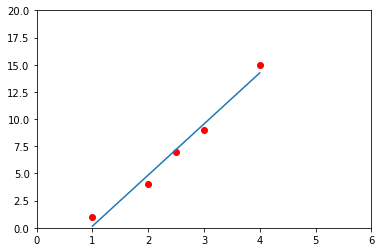

In [2]:
plt.plot(x,y,'ro')
plt.axis([0,6,0,20])
plt.plot(np.unique(x),np.poly1d(np.polyfit(x,y,1))(np.unique(x))) 
#np.unique returns the unique values in the array. 
#np.poly1d defines a polynomial function and makes it easy to apply "natural operations" on polynomials.
#np.polyfit fits data inside a polynomial function. It returns a vector of coefficients p that minimizes the squared error in the order of deg,deg-1,....,0
#It least squares the polynomial fit. It fits a polynomial p(X) of degree deg to points (X,Y)
plt.show()

---

# Coding example of Linear Regression

### Setup and Imports

In [3]:
from __future__ import absolute_import,division,print_function,unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import urllib

from tensorflow import feature_column as fc
import tensorflow as tf

### Data

The dataset used here is the famous Titanic dataset from kaggle.

In [4]:
#Load dataset
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') #training data
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') #testing data
y_train = dftrain.pop('survived') #removes the survived column from the dataset since this is the column we need to predict 
y_eval = dfeval.pop('survived')

Looking at the dataset

In [5]:
print(dftrain.head(5))

      sex   age  n_siblings_spouses  parch     fare  class     deck  \
0    male  22.0                   1      0   7.2500  Third  unknown   
1  female  38.0                   1      0  71.2833  First        C   
2  female  26.0                   0      0   7.9250  Third  unknown   
3  female  35.0                   1      0  53.1000  First        C   
4    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  


In [6]:
print(dftrain.loc[0])

sex                          male
age                          22.0
n_siblings_spouses              1
parch                           0
fare                         7.25
class                       Third
deck                      unknown
embark_town           Southampton
alone                           n
Name: 0, dtype: object


In [7]:
print(y_train.loc[0])

0


In [8]:
#for a more stastical view
print(dftrain.describe())

              age  n_siblings_spouses       parch        fare
count  627.000000          627.000000  627.000000  627.000000
mean    29.631308            0.545455    0.379585   34.385399
std     12.511818            1.151090    0.792999   54.597730
min      0.750000            0.000000    0.000000    0.000000
25%     23.000000            0.000000    0.000000    7.895800
50%     28.000000            0.000000    0.000000   15.045800
75%     35.000000            1.000000    0.000000   31.387500
max     80.000000            8.000000    5.000000  512.329200


In [9]:
#shape of the dataset
print(dftrain.shape)

(627, 9)


Here (627,9) indicates 627 enteries and 9 features.

---

# Exploratory Data Analysis

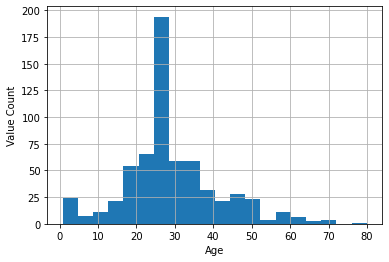

In [10]:
#plotting a histogram
dftrain.age.hist(bins=20)
plt.xlabel("Age")
plt.ylabel("Value Count")
plt.show()

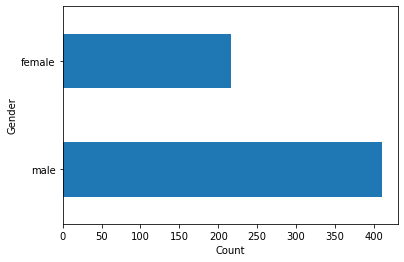

In [11]:
#Count plot based on sex of the passengers
dftrain.sex.value_counts().plot(kind="barh")
plt.xlabel("Count")
plt.ylabel("Gender")
plt.show()

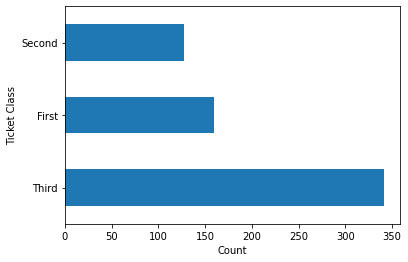

In [12]:
#count plot based on the ticket class
dftrain["class"].value_counts().plot(kind="barh")
plt.xlabel("Count")
plt.ylabel("Ticket Class")
plt.show()

Text(0.5, 0, '% survive')

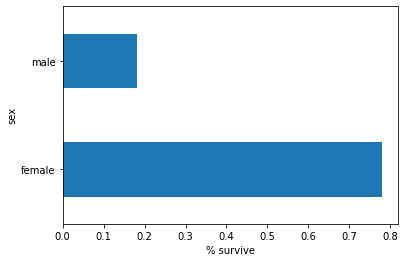

In [13]:
#Plot to show % survived
pd.concat([dftrain,y_train],axis=1).groupby("sex").survived.mean().plot(kind="barh").set_xlabel('% survive')

Results of EDA:
- Majority of passengers are in between the ages 20-30
- The majority of the passengers are males
- The majority of the passengers are in "Third" Class
- Females have a higher probabiltic rate of survival than men

---

# Categorical and Feature Data

Categorical Data is data that is not numerical. For e.g. In our dataset the class column has values such as "Third","Second" etc. i.e. different categories to the class of ticket

Categorical Data is usually made useful by converting them into integers i.e. 0 and 1 for two categories, 0,1 and 2 for three categories and so on...

Now we will segregate the categorical data from the numeric data in order to create our feature column array

A feature column is used to specify how tensors recieved from the input function should be combined and transformed before entering the model 

In [14]:
CATEGORICAL_COLUMNS = ['sex','n_siblings_spouses','parch','class','deck','embark_town','alone']
NUMERIC_COLUMNS = ['age','fare']

feature_columns = []

for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name,vocabulary))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name,dtype=tf.float32))


print(feature_columns)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

---

# Training Process

This section explains how input data is fed to the model.

For this specific model, the data is going to be streamed into it in small batches of 32. This means we will not feed the entire dataset to our model at once, but simply small batches of entries. These batches will be fed to the model multiple times, depending on the number of **epochs**

An **epoch** is defined as one stream of our entire dataset. The number of epochs we define is the amount of times our model will see the entire dataset.

We use multiple epochs in order to make our model see the same data over and over again so that it can get better at defining trends in data and estimate more accurate values.

e.g. If we hace 10 epochs, the model will see the same dataset for 10 times

# Input Function

Since we need to feed our data in batches and multiple times, we need to create an input function. The input function simply defines how our dataset will be converted into batches at each epoch.

The TensorFlow model we are going to use requires that the data we pass it comes in as a tf.data.Dataset object. This means we must create an input function that can convert our current pandas dataframe into that object.



In [15]:
#defining the input function

def make_input_fn(data_df,label_df,num_epochs=50,shuffle=True,batch_size=32):
    def input_function():
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df),label_df)) # create tf.data.Dataset object with data and its label
        if shuffle:
            ds = ds.shuffle(1000) # randomize order of data
        ds = ds.batch(batch_size).repeat(num_epochs) # split dataset into batches of 32 and repeat process for number of epochs
        return ds # return a batch of the dataset
    return input_function # return a function object for use


train_input_fn = make_input_fn(dftrain,y_train)
eval_input_fn = make_input_fn(dfeval,y_eval,num_epochs=1,shuffle=False)

---

# Creating the Model

Here we will use a linear estimator to utilize the linear regression algorithm.

Creating an estimator in TF : 

In [16]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Tanay\\AppData\\Local\\Temp\\tmpk1p67lga', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


---

# Training the model

Training the model will involve passing the input function created earlier to the estimator.

In [17]:
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()

In [18]:
print(result["accuracy"]*100.0,"%")

76.89393758773804 %


In [19]:
print(result)

{'accuracy': 0.7689394, 'accuracy_baseline': 0.625, 'auc': 0.8367309, 'auc_precision_recall': 0.7958385, 'average_loss': 0.5013764, 'label/mean': 0.375, 'loss': 0.48815665, 'precision': 0.6637931, 'prediction/mean': 0.46479854, 'recall': 0.7777778, 'global_step': 1000}


---

# Making Predictions

In [20]:
result = list(linear_est.predict(eval_input_fn))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Tanay\AppData\Local\Temp\tmpk1p67lga\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [21]:
print("Details about passenger 2 : ")
print(dfeval.loc[1])
print("**************")
print("Survived or not based on actual data : ")
print(y_eval.loc[1])
print("**************")
print("Model prediction on survivability rate : ")
print(result[0]['probabilities'][1],"%")

Details about passenger 2 : 
sex                          male
age                          54.0
n_siblings_spouses              0
parch                           0
fare                      51.8625
class                       First
deck                            E
embark_town           Southampton
alone                           y
Name: 1, dtype: object
**************
Survived or not based on actual data : 
0
**************
Model prediction on survivability rate : 
0.105404794 %
